# Integration
- This notebook will be integrating the final conclusions of the individual analysis that can be found in the same directory

# Variables
1. Housing Resale Prices
2. Marriage Count
3. Groceries
4. Income
5. Food Costs
6. School Fees

# Models Considered (Specific Variables)
- Logistic Regression
- Random Forest Classifier
- Bagging Classifier
    - We have trained our models multiple times using different seeds to get the top 5 best performing ones
    - So, we would like to see if simply using the best model trained or combining the top 5 will give a better model

During our analysis, we noticed that our specific variables can end up using different number of data points, due to lack of data points. This can range from only 100+ variables to about 500+ variables

We have also made changes to the dataset in our individual analysis, which may not be same for others.

Hence, we decided create separate models for each variable.

# Models Considered (Integrated)
Due to us training seperate models for our variables, integrating the datasets will result in missing values for some columns

Unfortunately, while the `Random Forest` algorithm should be able to support missing values, it seems that the `scikit-learn` library implementation does not support it.

Further research suggests to use `Gradient Boosting` to combine our separate models. However, due to how we approached this project, our models have been trained on different number of features, this caused some issues as some of this ensemble models requires the models to be trained on the same set of features.




# Performance Evaluation / Cross-Validation Techniques
We wanted to find some way to evaluate our models' performance and also to ensure that our performance is not a result of overfitting

We narrowed down to 2 techniques, due to our small datasets:
- K-Fold Cross-Validation
    - The process of splitting data set into `k` equally sized groups
    - Models will be trained on `k-1` of these folds and tested on the remaining one
    - This process will be repeated to test on every fold
        - E.g. If the number of folds is 3, we will get 3 trained models
    - We will then get the average of the 3 models' performance to evaluate our model
- Leave-One-Out Cross-Validation (LOOCV)
    - Similar to K-Fold, but it test on only 1 of the data points and train the model on the rest

While we might get a better performance evaluation if we use LOOCV, it gets very computational expensive despite our small dataset. Hence, we decided to use K-Fold, and to keep each fold to about 100 data points each

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

# Getting 5 random seeds
seeds = []
for i in range(5):
    seeds.append(random.randint(0, 100000))

# Main Dataset: Birth Count
## 1. Data Reading

In [3]:
# Importing birth rate data
birthData = pd.read_csv('Datasets/Birth_Rate_clean.csv')
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


## 2. Data Cleaning

In [4]:
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')

# Switch rows and columns (Transpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

         Total Live-Births By Ethnic Group
1960-01                               4981
1960-02                               4596
1960-03                               4964
1960-04                               4904
1960-05                               5244


<AxesSubplot:>

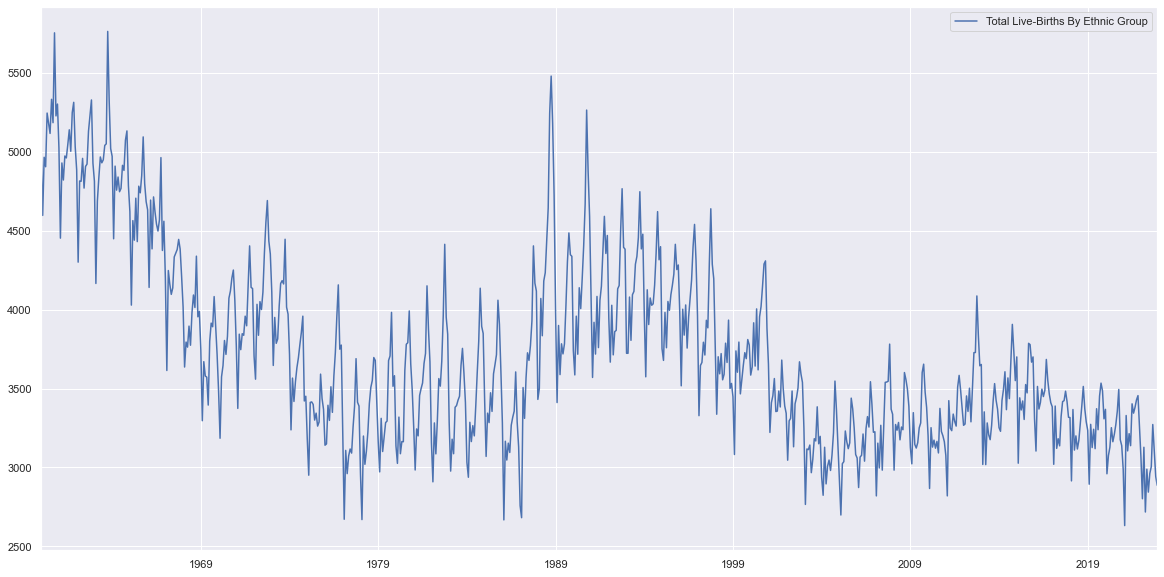

In [5]:
# Getting required column
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

print(babies.head())
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))

# Variable 1: Housing Resale Prices (Chee Han)
[Analysis](Housing%20Prices%20Analysis.ipynb)

## 1. Data Reading

In [6]:
houseResale = pd.concat(map(pd.read_csv, ['Datasets/Resale Flat Prices/Resale Approval Date 1990-1999.csv', 'Datasets/Resale Flat Prices/Resale Approval Date 2000-Feb-2012.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Mar-2012-Dec-2014.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Jan-2015-Dec-2016.csv', 'Datasets/Resale Flat Prices/Resale Registration Date Jan-2017-Onwards.csv']))
houseResale.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
149698,2023-03,YISHUN,EXECUTIVE,325,YISHUN CTRL,10 TO 12,146.0,Maisonette,1988,800000.0,64 years 08 months
149699,2023-03,YISHUN,EXECUTIVE,356,YISHUN RING RD,01 TO 03,146.0,Maisonette,1988,800000.0,64 years 06 months
149700,2023-03,YISHUN,EXECUTIVE,387,YISHUN RING RD,04 TO 06,142.0,Apartment,1988,770000.0,64 years 03 months
149701,2023-03,YISHUN,EXECUTIVE,792,YISHUN RING RD,10 TO 12,146.0,Maisonette,1987,818000.0,63 years 05 months
149702,2023-03,YISHUN,EXECUTIVE,640,YISHUN ST 61,01 TO 03,164.0,Apartment,1992,975000.0,68 years 03 months


## 2. Data Cleaning & Preparation

In [7]:
# Updating month column (Name and Datatype)
houseResale = houseResale.rename(columns = {'month':'Date'})
houseResale['Date'] = pd.to_datetime(houseResale['Date'])
houseResale['Date'] = houseResale['Date'].dt.strftime('%Y-%m')

# Standardizing flat_type and flat_models
houseResale['flat_type'] = ['MULTI-GENERATION' if x=='MULTI GENERATION' else x for x in houseResale['flat_type']]
houseResale['flat_model'] = [x.upper() for x in houseResale['flat_model']]

# Removing outliers
tempFrame = houseResale[['Date', 'flat_type', 'flat_model', 'resale_price']].copy()
flatType = ['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
separateType = []

for flat in flatType:
    temp = tempFrame.loc[tempFrame['flat_type'] == flat]
    Q3 = temp['resale_price'].quantile(0.25)
    Q1 = temp['resale_price'].quantile(0.75)
    IQR = Q1-Q3
    separateType.append(temp[~((temp['resale_price'] < (Q1 - 1.5*IQR)) | (temp['resale_price'] > (Q3 + 1.5*IQR)))])
    
# Ignore flat_model
tempFrame = pd.concat(separateType).reset_index().drop(['index'], axis=1)
tempFrame = tempFrame.groupby(['Date', 'flat_type'])['resale_price'].mean().round(2).to_frame()
tempFrame = tempFrame.round(2)
tempFrame = tempFrame.rename(columns={'resale_price': 'avg_resale'}).reset_index()

In [8]:
tempFrame.head()

,Date,flat_type,avg_resale
0,1990-01,3 ROOM,77980.00
1,1990-01,4 ROOM,149500.00
2,1990-02,3 ROOM,75690.91
3,1990-02,4 ROOM,152533.33
4,1990-03,3 ROOM,82060.00


In [9]:
# Getting avg_resale dataframe for 3R, 4R and 5R
temp3R = tempFrame.loc[tempFrame['flat_type'] == '3 ROOM']
temp3R = temp3R.set_index('Date')
temp3R.index = pd.to_datetime(temp3R.index).to_period('M')

temp4R = tempFrame.loc[tempFrame['flat_type'] == '4 ROOM']
temp4R = temp4R.set_index('Date')
temp4R.index = pd.to_datetime(temp4R.index).to_period('M')

temp5R = tempFrame.loc[tempFrame['flat_type'] == '5 ROOM']
temp5R = temp5R.set_index('Date')
temp5R.index = pd.to_datetime(temp5R.index).to_period('M')

In [10]:
# Getting copy of birth dataframe
housingBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
housingBaby['Next Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(-1)
housingBaby['Prev Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(1)

# Dropping NaN rows (First and Last Row)
housingBaby = housingBaby.dropna()

housing3R = housingBaby.join(temp3R['avg_resale'], how='inner').rename(columns={'avg_resale': '3R Avg'})
housing4R = housingBaby.join(temp4R['avg_resale'], how='inner').rename(columns={'avg_resale': '4R Avg'})
housing5R = housingBaby.join(temp5R['avg_resale'], how='inner').rename(columns={'avg_resale': '5R Avg'})

housingMerge = pd.concat([housing3R, housing4R, housing5R], axis=1, join='inner')
housingMerge = housingMerge.loc[:,~housingMerge.columns.duplicated(keep='first')]
housingMerge.info()
housingMerge.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 373 entries, 1991-07 to 2022-11
Freq: M
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  373 non-null    int64  
 1   Next Month Birth                   373 non-null    float64
 2   Prev Month Birth                   373 non-null    float64
 3   3R Avg                             373 non-null    float64
 4   4R Avg                             373 non-null    float64
 5   5R Avg                             373 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 20.4 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,3R Avg,4R Avg,5R Avg
Total Live-Births By Ethnic Group,1.000000,0.849316,0.845988,-0.508727,-0.434129,-0.311686
Next Month Birth,0.849316,1.000000,0.790944,-0.510863,-0.437168,-0.318515
Prev Month Birth,0.845988,0.790944,1.000000,-0.504473,-0.429592,-0.301726
3R Avg,-0.508727,-0.510863,-0.504473,1.000000,0.984329,0.917998
4R Avg,-0.434129,-0.437168,-0.429592,0.984329,1.000000,0.969291
5R Avg,-0.311686,-0.318515,-0.301726,0.917998,0.969291,1.000000


<AxesSubplot:>

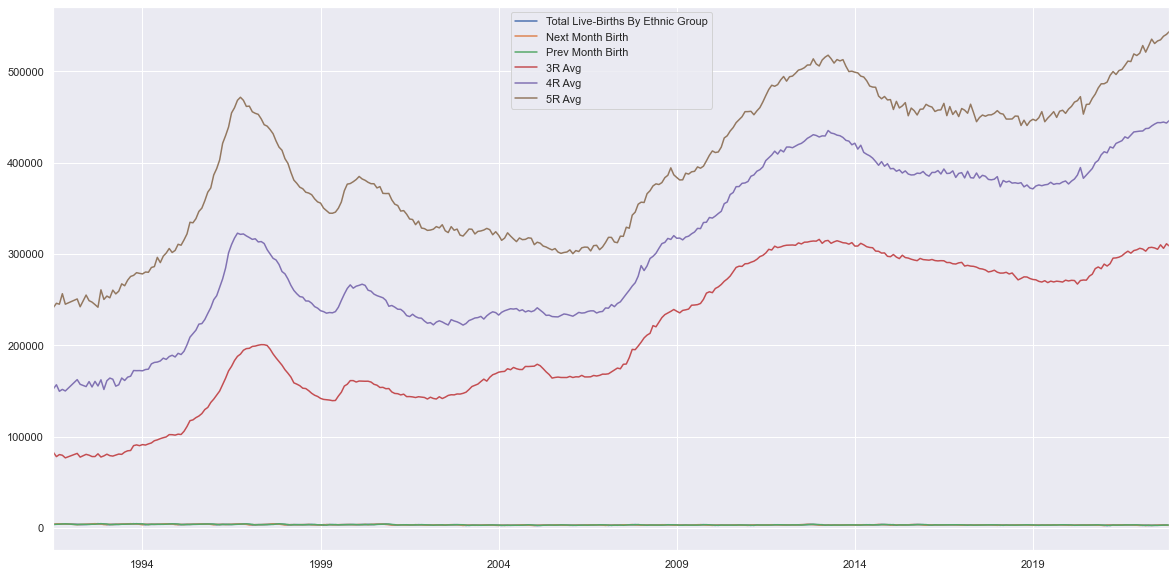

In [11]:
housingMerge.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - 3R Avg
    - 4R Avg
    - 5R Avg
- Response: Rise-Fall

In [12]:
# Step 1: Creating binary target variable
housingMerge['Rise-Fall'] = (housingMerge['Total Live-Births By Ethnic Group'] > housingMerge['Next Month Birth']).astype(int)

In [13]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingMerge[['Total Live-Births By Ethnic Group', 'Prev Month Birth',
                       '3R Avg', '4R Avg', '5R Avg']]

    # Step 2.2: Response
    y = housingMerge['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [14]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 82516:
Accuracy  = 0.7333
Precision = 0.7500
Recall    = 0.7500
F1 score  = 0.7500
----------------------------------------------
Random state 60903:
Accuracy  = 0.7467
Precision = 0.6757
Recall    = 0.7812
F1 score  = 0.7246
----------------------------------------------
Random state 13453:
Accuracy  = 0.6533
Precision = 0.6500
Recall    = 0.6842
F1 score  = 0.6667
----------------------------------------------
Random state 66193:
Accuracy  = 0.6267
Precision = 0.5319
Recall    = 0.8065
F1 score  = 0.6410
----------------------------------------------
Random state 53391:
Accuracy  = 0.6400
Precision = 0.6154
Recall    = 0.6667
F1 score  = 0.6400
----------------------------------------------


In [15]:
# Final Model to use for Variable 1
houseMod = results[0][-1]

# Variable 2: Marriage Count (Chee Han)
[Analysis](Marriage%20Analysis.ipynb)

## 1. Data Reading

In [16]:
# Reading Total Marriage data
marriageCount = pd.read_csv("Datasets/Marriage_clean.csv")
marriageCount.head()

,Data Series,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1970,1969,1968,1967,1966,1965,1964,1963,1962,1961
0,Total Marriages (Number),28329.0,22651.0,25434.0,27007.0,28212.0,27971.0,28322.0,28407.0,26254.0,...,14572,12629,11552,10960,10226,8993,7810,7056,6044,5224
1,First Marriages (Number),22808.0,17789.0,19356.0,20822.0,21806.0,21364.0,21639.0,21555.0,19706.0,...,13889,na,na,na,na,na,na,na,na,na
2,Remarriages (Number),5521.0,4862.0,6078.0,6185.0,6406.0,6607.0,6683.0,6852.0,6548.0,...,683,na,na,na,na,na,na,na,na,na
3,Remarriages - One Partner (Number),3568.0,3104.0,3854.0,3976.0,4227.0,4423.0,4442.0,4682.0,4432.0,...,533,na,na,na,na,na,na,na,na,na
4,Remarriages - Both Partners (Number),1953.0,1758.0,2224.0,2209.0,2179.0,2184.0,2241.0,2170.0,2116.0,...,150,na,na,na,na,na,na,na,na,na


## 2. Data Cleaning & Preparation

In [17]:
# Renaming & setting index column
marriageCount = marriageCount.rename(columns = {'Data Series':'Date'})
marriageCount.set_index('Date',inplace=True)
marriageCount.columns = pd.DatetimeIndex(marriageCount.columns).to_period('M')

# Switch row and columns (Transpose)
marriageCount = marriageCount.T
marriageCount = marriageCount.rename(columns=lambda x: x.strip()).sort_index()

# Update data type to remove decimal point
totalMarriage = marriageCount.rename(columns = {'Total Marriages (Number)':'Total Marriages'}).astype({'Total Marriages':'int'})[['Total Marriages']]

In [18]:
print(len(totalMarriage))
totalMarriage.tail()

61


Date,Total Marriages
2017-01,28212
2018-01,27007
2019-01,25434
2020-01,22651
2021-01,28329


In [19]:
# Removing Outliers
Q3 = totalMarriage['Total Marriages'].quantile(0.25)
Q1 = totalMarriage['Total Marriages'].quantile(0.75)
IQR = Q1-Q3
totalMarriage = totalMarriage[~((totalMarriage['Total Marriages'] < (Q1 - 1.5*IQR)) | (totalMarriage['Total Marriages'] > (Q3 + 1.5*IQR)))]

In [20]:
print(len(totalMarriage))
totalMarriage.tail()

43


Date,Total Marriages
2011-01,27258
2013-01,26254
2018-01,27007
2019-01,25434
2020-01,22651


In [21]:
# Monthly Marriage Rate Calculation
monthlyRate = [1963, 1492, 2041, 1314, 2034, 2220, 1814, 1849, 2315, 2046, 2641, 2867]
sumOfMonthly = sum(monthlyRate)
monthlyRate = [x/sumOfMonthly for x in monthlyRate]

# Breaking down annual to monthly
marriageSplit = pd.DataFrame(columns=['Date', 'Current Marriage Count']).astype({'Current Marriage Count':'int'})
for index, row in totalMarriage.iterrows():
    date = index
    total = row['Total Marriages']
    for i in range(12):
        marriageSplit = pd.concat([marriageSplit, pd.DataFrame({'Date':[date + pd.offsets.MonthEnd(i)], 'Current Marriage Count':[(int)(total*monthlyRate[i])]})])
marriageSplit.set_index('Date',inplace=True)

<AxesSubplot:>

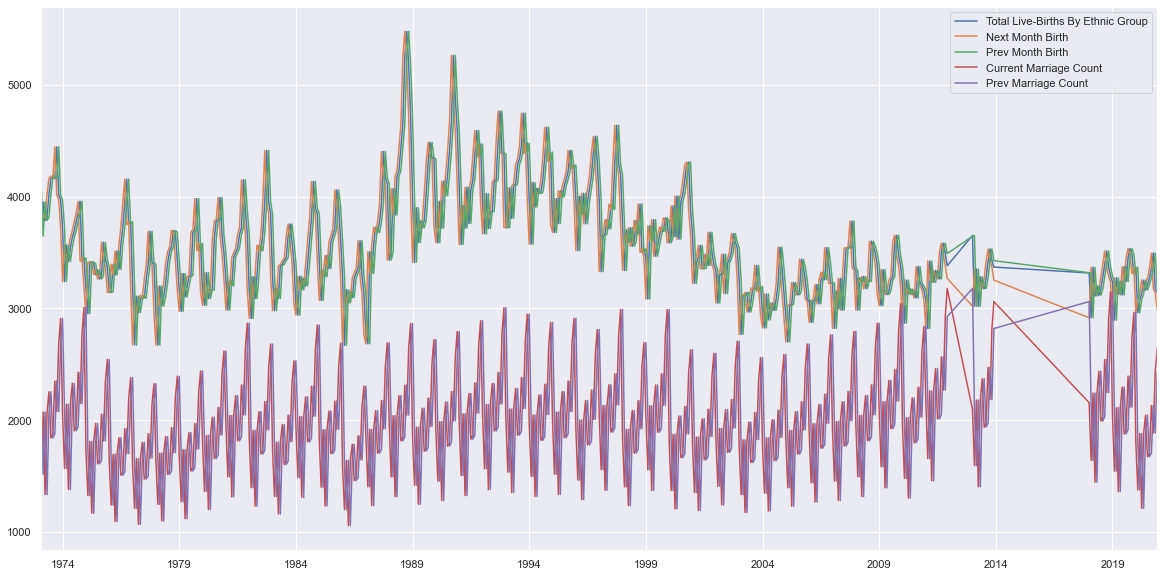

In [22]:
# Copy of Birth Data
marriageBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
marriageBaby['Next Month Birth'] = marriageBaby['Total Live-Births By Ethnic Group'].shift(-1)
marriageBaby['Prev Month Birth'] = marriageBaby['Total Live-Births By Ethnic Group'].shift(1)

marriageSplit = pd.concat([marriageBaby, marriageSplit], axis=1, join='inner')
marriageSplit['Prev Marriage Count'] = marriageSplit['Current Marriage Count'].shift(1)

# Remove NaN rows
marriageSplit = marriageSplit.dropna()

marriageSplit.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - Marriage Count
    - Prev Count
- Response: Rise-Fall

In [23]:
# Step 1: Create binary target variable
marriageSplit['Rise-Fall'] = (marriageSplit['Total Live-Births By Ethnic Group'] > marriageSplit['Next Month Birth']).astype(int)

In [24]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = marriageSplit[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Current Marriage Count', 'Prev Marriage Count']]

    # Step 2.2: Response
    y = marriageSplit['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [25]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 82516:
Accuracy  = 0.8447
Precision = 0.8095
Recall    = 0.8095
F1 score  = 0.8095
----------------------------------------------
Random state 60903:
Accuracy  = 0.8058
Precision = 0.7609
Recall    = 0.7955
F1 score  = 0.7778
----------------------------------------------
Random state 13453:
Accuracy  = 0.7864
Precision = 0.7609
Recall    = 0.7609
F1 score  = 0.7609
----------------------------------------------
Random state 66193:
Accuracy  = 0.7670
Precision = 0.7755
Recall    = 0.7451
F1 score  = 0.7600
----------------------------------------------
Random state 53391:
Accuracy  = 0.7573
Precision = 0.6250
Recall    = 0.8108
F1 score  = 0.7059
----------------------------------------------


In [26]:
marriageMod = results[0][-1]

# Variable 3: Education Cost (Zai Qin)
[Analysis](Education%20Cost%20Analysis.ipynb)

## 1. Data Reading

In [27]:
# Variable: Education Costs
edu = pd.read_csv("Datasets/Education_clean.csv")

## 2. Data Cleaning

In [28]:
edu = edu.rename(columns = {'Data Series':'Date','Education':'Total'})
birthData = birthData.rename(columns=lambda x: x.strip())
edu['Date'] = pd.to_datetime(edu['Date'])
edu['Date'] = edu['Date'].dt.strftime('%Y-%m')

edu = edu.set_index('Date')
edu.index = pd.to_datetime(edu.index).to_period('M')

# Set missing 'na' data to 0
edu = edu.fillna(0)
edu.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 745 entries, 2023-01 to 1961-01
Freq: M
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Total                                745 non-null    float64
 1   Tuition & Other Fees (Extrapolated)  745 non-null    float64
 2   Textbooks & Guides (Extrapolated)    745 non-null    float64
 3   Tuition & Other Fees                 745 non-null    float64
 4   Textbooks & Guides                   745 non-null    float64
dtypes: float64(5)
memory usage: 34.9 KB


<AxesSubplot:xlabel='Date'>

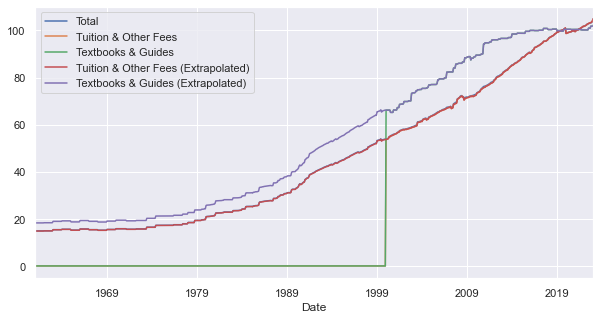

In [29]:
eduMerge = pd.concat([edu['Total'], edu['Tuition & Other Fees'], edu['Textbooks & Guides'], edu['Tuition & Other Fees (Extrapolated)'], edu['Textbooks & Guides (Extrapolated)']], axis=1, join='inner')
eduMerge = eduMerge.loc[:,~eduMerge.columns.duplicated(keep='first')]
eduMerge.plot(figsize=(10, 5))

<AxesSubplot:>

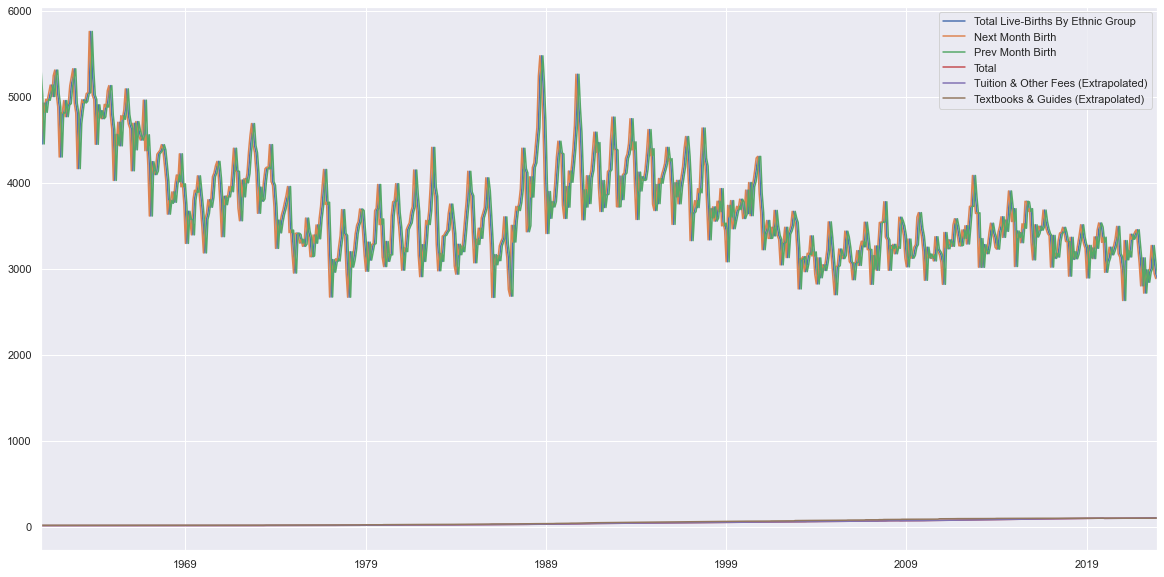

In [30]:
eduBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
eduBaby['Next Month Birth'] = eduBaby['Total Live-Births By Ethnic Group'].shift(-1)
eduBaby['Prev Month Birth'] = eduBaby['Total Live-Births By Ethnic Group'].shift(1)
eduTotal = eduBaby.join(edu['Total'], how='inner')
eduTuitionEx = eduBaby.join(edu['Tuition & Other Fees (Extrapolated)'], how='inner')
eduTextEx = eduBaby.join(edu['Textbooks & Guides (Extrapolated)'], how='inner')
eduUpdate = pd.concat([eduTotal,eduTuitionEx, eduTextEx], axis=1, join='inner')
eduUpdate = eduUpdate.loc[:,~eduUpdate.columns.duplicated(keep='first')]
eduUpdate.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - Total
    - Tuition & Other Fees (Extrapolated)
    - Textbook & Guides (Extrapolated)
- Response: Rise-Fall

In [31]:
# Step 1: Create binary target variable
eduUpdate['Rise-Fall'] = (eduUpdate['Total Live-Births By Ethnic Group'] > eduUpdate['Next Month Birth']).astype(int)

In [32]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = eduUpdate[['Total Live-Births By Ethnic Group',
                   'Prev Month Birth', 'Total', 'Tuition & Other Fees (Extrapolated)', 'Textbooks & Guides (Extrapolated)']]

    # Step 2.2: Response
    y = eduUpdate['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [33]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 66193:
Accuracy  = 0.6376
Precision = 0.6047
Recall    = 0.7222
F1 score  = 0.6582
----------------------------------------------
Random state 53391:
Accuracy  = 0.6510
Precision = 0.6076
Recall    = 0.6957
F1 score  = 0.6486
----------------------------------------------
Random state 13453:
Accuracy  = 0.6644
Precision = 0.6119
Recall    = 0.6308
F1 score  = 0.6212
----------------------------------------------
Random state 60903:
Accuracy  = 0.6309
Precision = 0.6379
Recall    = 0.5211
F1 score  = 0.5736
----------------------------------------------
Random state 82516:
Accuracy  = 0.5772
Precision = 0.5915
Recall    = 0.5526
F1 score  = 0.5714
----------------------------------------------


In [34]:
eduCostMod = results[0][-1]

# Variable 4: Food Cost (Zai Qin)
[Analysis](Education%20Cost%20Analysis.ipynb)

## 1. Data Reading

In [35]:
food = pd.read_csv('Datasets/FnB_Services_Index.csv', header = 0)

## 2. Data Cleaning & Preparation

In [36]:
food = food.rename(columns = {'Data Series':'Date','Fast Food Outlets':'Fast Food','Cafes, Food Courts & Other Eating Places':'Others'})
birthData = birthData.rename(columns=lambda x: x.strip())
food['Date'] = pd.to_datetime(food['Date'])
food['Date'] = food['Date'].dt.strftime('%Y-%m')

food = food.set_index('Date')
food.index = pd.to_datetime(food.index).to_period('M')
# Set missing 'na' data to 0
food = food.fillna(0)
food.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 457 entries, 2023-01 to 1985-01
Freq: M
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total          457 non-null    float64
 1   Restaurants    457 non-null    float64
 2   Fast Food      457 non-null    float64
 3   Food Caterers  457 non-null    float64
 4   Others         457 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB


<AxesSubplot:>

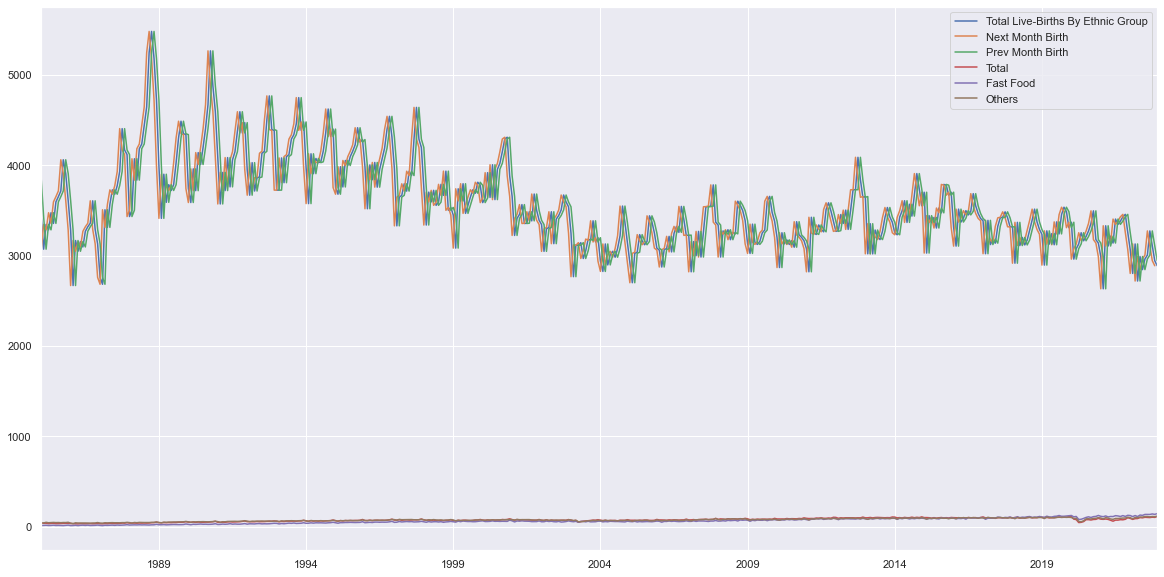

In [37]:
foodBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
foodBaby['Next Month Birth'] = foodBaby['Total Live-Births By Ethnic Group'].shift(-1)
foodBaby['Prev Month Birth'] = foodBaby['Total Live-Births By Ethnic Group'].shift(1)
foodTotal = foodBaby.join(food['Total'], how='inner')
foodFastFood = foodBaby.join(food['Fast Food'], how='inner')
foodOthers = foodBaby.join(food['Others'], how='inner')
foodMerge = pd.concat([foodTotal, foodFastFood, foodOthers], axis=1, join='inner')
foodMerge = foodMerge.loc[:,~foodMerge.columns.duplicated(keep='first')]
foodMerge.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - Total
    - Fast Food
    - Others
- Response: Rise-Fall

In [38]:
# Step 1: Create binary target variable
foodMerge['Rise-Fall'] = (foodMerge['Total Live-Births By Ethnic Group'] > foodMerge['Next Month Birth']).astype(int)

In [39]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = foodMerge[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Total', 'Fast Food','Others']]

    # Step 2.2: Response
    y = foodMerge['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [40]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 60903:
Accuracy  = 0.6630
Precision = 0.6600
Recall    = 0.7021
F1 score  = 0.6804
----------------------------------------------
Random state 53391:
Accuracy  = 0.6413
Precision = 0.7333
Recall    = 0.6111
F1 score  = 0.6667
----------------------------------------------
Random state 13453:
Accuracy  = 0.6739
Precision = 0.7179
Recall    = 0.5957
F1 score  = 0.6512
----------------------------------------------
Random state 66193:
Accuracy  = 0.6413
Precision = 0.6190
Recall    = 0.6047
F1 score  = 0.6118
----------------------------------------------
Random state 82516:
Accuracy  = 0.5978
Precision = 0.6829
Recall    = 0.5385
F1 score  = 0.6022
----------------------------------------------


In [41]:
fooCostMod = results[0][-1]

# Variable 5: Marriage Age (Zai Qin)
[Analysis](Marriage%20Age%20Analysis.ipynb)

## 1. Data Reading

In [42]:
age = pd.read_csv("Datasets/Marriage Age.csv")

## 2. Data Cleaning & Preparation

In [43]:
age = age.rename(columns = {'Data Series':'Date'})
age = age.set_index('Date')
age = age.sort_index()
age.head()

,Resident Grooms,Resident Brides,Citizen Grooms,Citizen Brides
Date,,,,
1984,26.9,24.1,26.9,24.1
1985,27.0,24.2,26.9,24.2
1986,27.1,24.4,27.1,24.3
1987,27.5,24.7,27.5,24.7
1988,27.6,24.8,27.6,24.8


In [44]:
ageResGm = pd.DataFrame(age['Resident Grooms'])
ageResBr = pd.DataFrame(age['Resident Brides'])
ageCitGm = pd.DataFrame(age['Citizen Grooms'])
ageCitBr = pd.DataFrame(age['Citizen Brides'])

ageResGm.index = pd.to_datetime(ageResGm.index, format='%Y')
ageResBr.index = pd.to_datetime(ageResBr.index, format='%Y')
ageCitGm.index = pd.to_datetime(ageCitGm.index, format='%Y')
ageCitBr.index = pd.to_datetime(ageCitBr.index, format='%Y')

<AxesSubplot:title={'center':'Median Age of Marriages Per Month'}, xlabel='Date'>

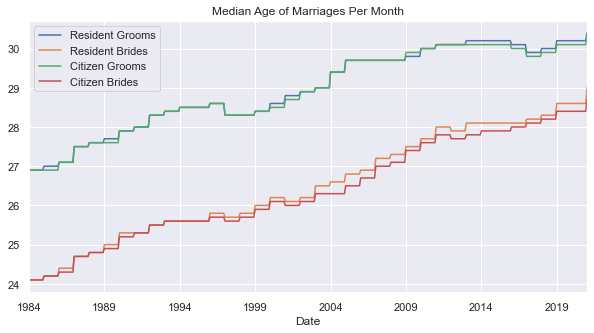

In [45]:
ageResGmMonthly = ageResGm.resample('MS').ffill().to_period('M')
ageResBrMonthly = ageResBr.resample('MS').ffill().to_period('M')
ageCitGmMonthly = ageCitGm.resample('MS').ffill().to_period('M')
ageCitBrMonthly = ageCitBr.resample('MS').ffill().to_period('M')

ageResBrMonthly = ageResGmMonthly.join(ageResBrMonthly['Resident Brides'], how='inner')
ageCitGmMonthly = ageResGmMonthly.join(ageCitGmMonthly['Citizen Grooms'], how='inner')
ageCitBrMonthly = ageResGmMonthly.join(ageCitBrMonthly['Citizen Brides'], how='inner')

ageMerge = pd.concat([ageResGmMonthly,ageResBrMonthly,ageCitGmMonthly,ageCitBrMonthly], axis=1, join='inner')
ageMerge = ageMerge.loc[:,~ageMerge.columns.duplicated(keep='first')]
ageMerge.plot(figsize=(10, 5), title='Median Age of Marriages Per Month')

<AxesSubplot:>

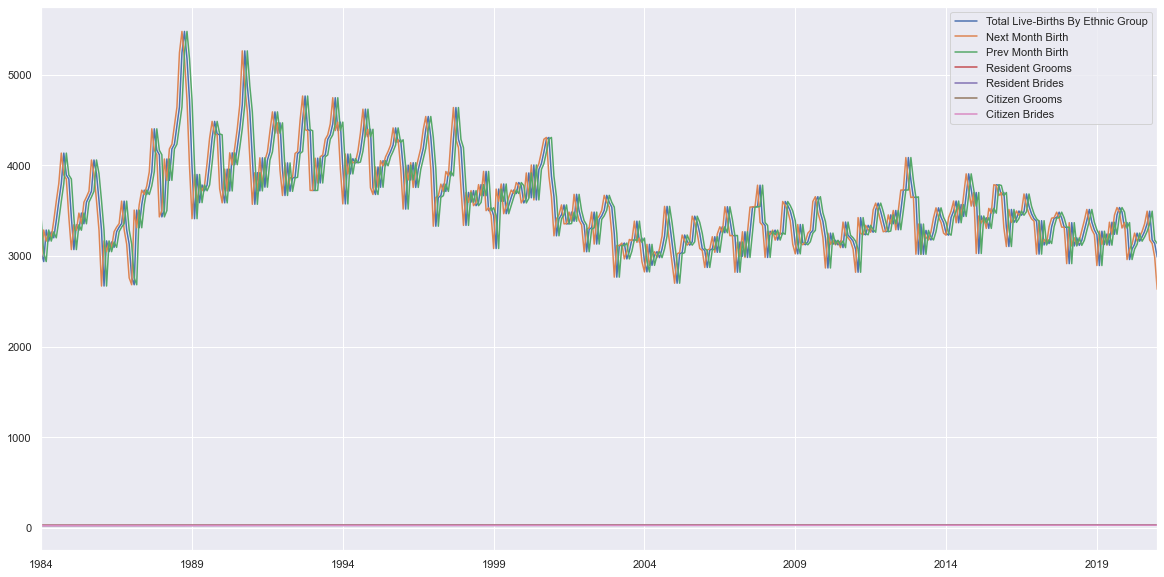

In [46]:
ageBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
ageBaby['Next Month Birth'] = ageBaby['Total Live-Births By Ethnic Group'].shift(-1)
ageBaby['Prev Month Birth'] = ageBaby['Total Live-Births By Ethnic Group'].shift(1)

ageResGmMonthly = ageBaby.join(ageResGmMonthly['Resident Grooms'], how='inner')
ageResBrMonthly = ageBaby.join(ageResBrMonthly['Resident Brides'], how='inner')
ageCitGmMonthly = ageBaby.join(ageCitGmMonthly['Citizen Grooms'], how='inner')
ageCitBrMonthly = ageBaby.join(ageCitBrMonthly['Citizen Brides'], how='inner')

ageMerge = pd.concat([ageResGmMonthly,ageResBrMonthly,ageCitGmMonthly,ageCitBrMonthly], axis=1, join='inner')
ageMerge = ageMerge.loc[:,~ageMerge.columns.duplicated(keep='first')]
ageMerge.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - Resident Grooms
    - Resident Brides
    - Citizen Grooms
    - Citizen Brides
- Response: Rise-Fall

In [47]:
# Step 1: Create binary target variable
ageMerge['Rise-Fall'] = (ageMerge['Total Live-Births By Ethnic Group'] > ageMerge['Next Month Birth']).astype(int)

In [48]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = ageMerge[['Total Live-Births By Ethnic Group',
                   'Prev Month Birth', 'Resident Grooms', 'Resident Brides', 'Citizen Grooms', 'Citizen Brides']]

    # Step 2.2: Response
    y = ageMerge['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [49]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 60903:
Accuracy  = 0.6966
Precision = 0.7660
Recall    = 0.6923
F1 score  = 0.7273
----------------------------------------------
Random state 82516:
Accuracy  = 0.6517
Precision = 0.7105
Recall    = 0.5745
F1 score  = 0.6353
----------------------------------------------
Random state 66193:
Accuracy  = 0.6854
Precision = 0.6216
Recall    = 0.6216
F1 score  = 0.6216
----------------------------------------------
Random state 53391:
Accuracy  = 0.6517
Precision = 0.6410
Recall    = 0.5952
F1 score  = 0.6173
----------------------------------------------
Random state 13453:
Accuracy  = 0.6292
Precision = 0.5909
Recall    = 0.6341
F1 score  = 0.6118
----------------------------------------------


In [50]:
marAgeMod = results[0][-1]

# Variable 6: Income (Joseph)
[Analysis](Income%20Analysis.ipynb)

## 1. Data Reading

In [51]:
income = pd.read_csv('Datasets/Income_clean.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Data Cleaning & Preparation

In [52]:
income.set_index('Year',inplace=True)
income.columns = income.columns.str.replace('-','')

income = income.sort_index()
income.head()

,HDB 1 & 2 Room Flats,HDB 3Room Flats,HDB 4Room Flats,HDB 5Room & Executive Flats,Condominiums & Other Apartments,Landed Properties
Year,,,,,,
2000,876,1344,1305,1880,4035,3350
2001,803,1455,1414,2074,4524,3641
2002,807,1352,1390,2044,4173,3563
2003,773,1416,1362,1985,4228,3441
2004,811,1404,1358,1929,3961,3757


In [53]:
income1rm = pd.DataFrame(income['HDB 1 & 2 Room Flats'])
income3rm = pd.DataFrame(income['HDB 3Room Flats'])
income4rm = pd.DataFrame(income['HDB 4Room Flats'])
income5exec = pd.DataFrame(income['HDB 5Room & Executive Flats'])
incomeCondo = pd.DataFrame(income['Condominiums & Other Apartments'])
incomeLanded = pd.DataFrame(income['Landed Properties'])


income1rm.index = pd.to_datetime(income1rm.index, format='%Y')
income3rm.index = pd.to_datetime(income3rm.index, format='%Y')
income4rm.index = pd.to_datetime(income4rm.index, format='%Y')
income5exec.index = pd.to_datetime(income5exec.index, format='%Y')
incomeCondo.index = pd.to_datetime(incomeCondo.index, format='%Y')
incomeLanded.index = pd.to_datetime(incomeLanded.index, format='%Y')

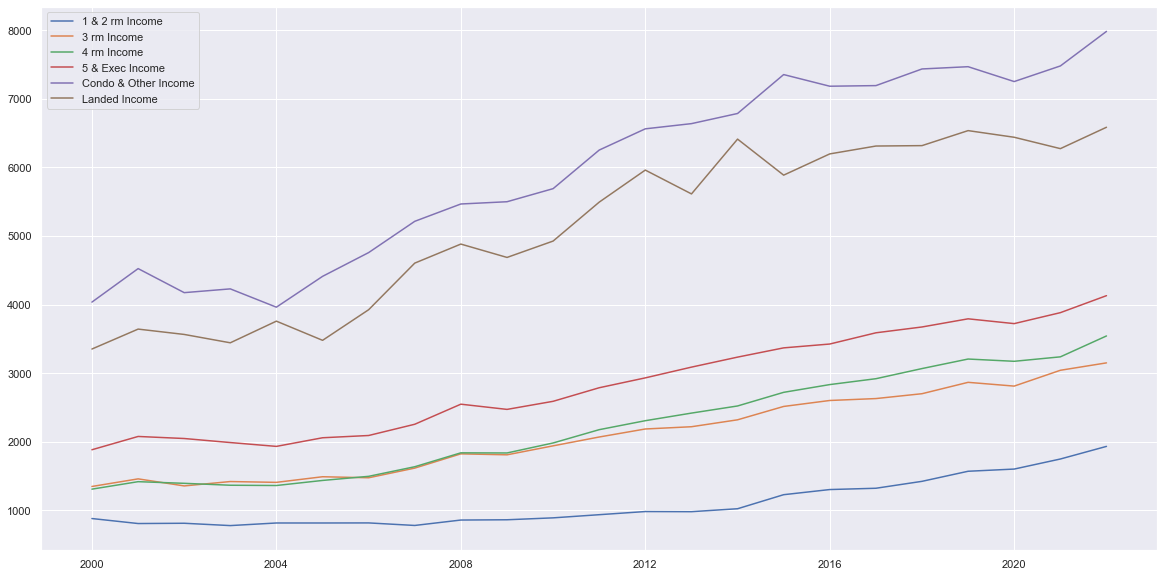

In [54]:
plt.figure(figsize=(20,10))
plt.plot(income1rm, label='1 & 2 rm Income');
plt.plot(income3rm, label='3 rm Income');
plt.plot(income4rm, label='4 rm Income');
plt.plot(income5exec, label='5 & Exec Income');
plt.plot(incomeCondo, label='Condo & Other Income');
plt.plot(incomeLanded, label='Landed Income');
plt.legend()

In [55]:
income1rm_monthly = income1rm.resample('MS').ffill().to_period('M')
income3rm_monthly = income3rm.resample('MS').ffill().to_period('M')
income4rm_monthly = income4rm.resample('MS').ffill().to_period('M')
income5exec_monthly = income5exec.resample('MS').ffill().to_period('M')
incomeCondo_monthly = incomeCondo.resample('MS').ffill().to_period('M')
incomeLanded_monthly = incomeLanded.resample('MS').ffill().to_period('M')

<AxesSubplot:>

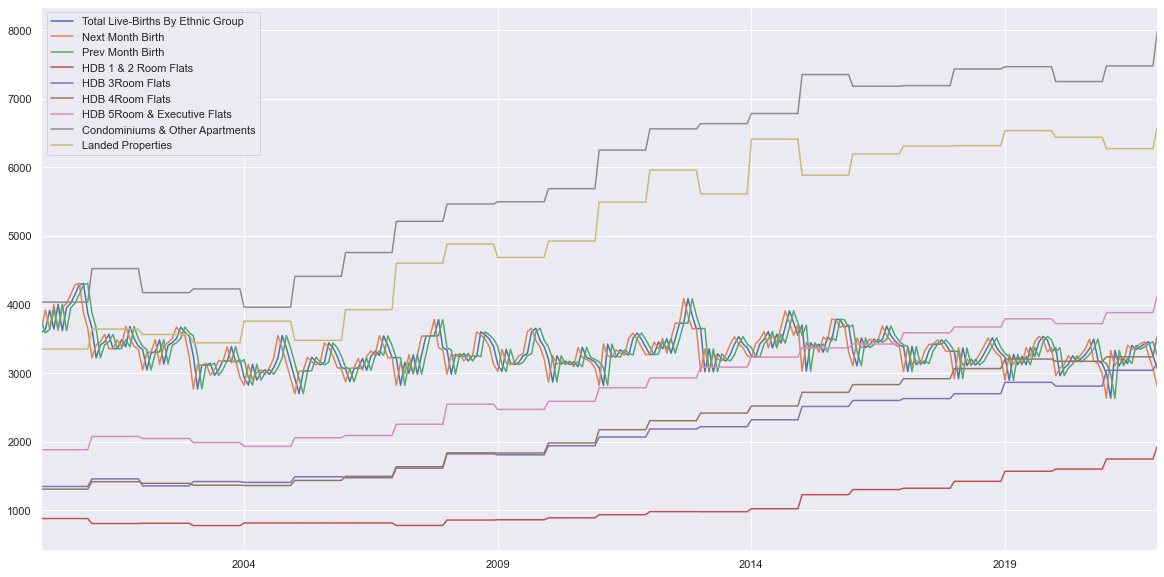

In [56]:
incomebirths = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
incomebirths['Next Month Birth'] = incomebirths['Total Live-Births By Ethnic Group'].shift(-1)
incomebirths['Prev Month Birth'] = incomebirths['Total Live-Births By Ethnic Group'].shift(1)

incomebirths = incomebirths.dropna()

income1rm_monthly = incomebirths.join(income1rm_monthly['HDB 1 & 2 Room Flats'], how='inner')
income3rm_monthly = incomebirths.join(income3rm_monthly['HDB 3Room Flats'], how='inner')
income4rm_monthly = incomebirths.join(income4rm_monthly['HDB 4Room Flats'], how='inner')
income5exec_monthly = incomebirths.join(income5exec_monthly['HDB 5Room & Executive Flats'], how='inner')
incomeCondo_monthly = incomebirths.join(incomeCondo_monthly['Condominiums & Other Apartments'], how='inner')
incomeLanded_monthly = incomebirths.join(incomeLanded_monthly['Landed Properties'], how='inner')

incomeMerge = pd.concat([income1rm_monthly,income3rm_monthly,income4rm_monthly,income5exec_monthly,incomeCondo_monthly,incomeLanded_monthly], axis=1, join='inner')
incomeMerge = incomeMerge.loc[:,~incomeMerge.columns.duplicated(keep='first')]
incomeMerge.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - HDB 1 & 2 Room Flats
    - HDB 3Room Flats
    - HDB 4Room Flats
    - HDB 5Room & Executive Flats
    - Condominiums & Other Apartments
    - Landed Properties
- Response: Rise-Fall

In [57]:
# Step 1: Create binary target variable
incomeMerge['Rise-Fall'] = (incomeMerge['Total Live-Births By Ethnic Group'] > incomeMerge['Next Month Birth']).astype(int)

In [58]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = incomeMerge[['Total Live-Births By Ethnic Group', 'HDB 1 & 2 Room Flats','HDB 3Room Flats', 
                     'HDB 4Room Flats', 'HDB 5Room & Executive Flats']]

    # Step 2.2: Response
    y = incomeMerge['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [59]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 66193:
Accuracy  = 0.6415
Precision = 0.6897
Recall    = 0.6667
F1 score  = 0.6780
----------------------------------------------
Random state 82516:
Accuracy  = 0.6226
Precision = 0.7308
Recall    = 0.5938
F1 score  = 0.6552
----------------------------------------------
Random state 53391:
Accuracy  = 0.6038
Precision = 0.5909
Recall    = 0.5200
F1 score  = 0.5532
----------------------------------------------
Random state 13453:
Accuracy  = 0.5660
Precision = 0.6667
Recall    = 0.4667
F1 score  = 0.5490
----------------------------------------------
Random state 60903:
Accuracy  = 0.6038
Precision = 0.5882
Recall    = 0.4167
F1 score  = 0.4878
----------------------------------------------


In [60]:
incomeMod = results[0][-1]

# Variable 7: Grocery (Joseph)
[Analysis](Grocery%20Analysis.ipynb)

## 1. Data Reading

In [61]:
cpi = pd.read_csv('Datasets/Groceries_clean.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Data Cleaning & Preparation

In [62]:
#set data series as index and convert to date time
cpi = cpi.rename(columns = {'Data Series':'Date'})
cpi.set_index('Date',inplace=True)
cpi = cpi.rename(columns=lambda x: x.strip())
cpi.columns = pd.DatetimeIndex(cpi.columns).to_period('M')

cpi = cpi.T
cpi = cpi.rename(columns=lambda x: x.strip())
cpi = cpi.reindex()
cpi.head()

Date,All Items,Food,Food Excl Food Serving Services,Bread & Cereals,Meat,Fish & Seafood,"Milk, Cheese & Eggs",Oils & Fats,Fruits,Vegetables,"Sugar, Preserves & Confectionery",Non-Alcoholic Beverages,Other Food,Food Serving Services,Restaurant Food,Fast Food,Hawker Food,Catered Food,Clothing & Footwear,Clothing,Other Articles & Related Services,Footwear,Housing & Utilities,Accommodation,Utilities & Other Fuels,Household Durables & Services,Household Durables,Household Services & Supplies,Health Care,Medicines & Health Products,Outpatient Services,Hospital Services,Health Insurance,Transport,Private Transport,Public Transport,Other Transport Services,Communication,Postage & Courier Services,Telecommunication Equipment,Telecommunication Services,Recreation & Culture,Recreational & Cultural Goods,Recreational & Cultural Services,"Newspapers, Books & Stationery",Holiday Expenses,Education,Tuition & Other Fees,Textbooks & Guides,Miscellaneous Goods & Services,Personal Care,Alcoholic Drinks & Tobacco,Personal Effects,Social Services,Other Miscellaneous Services,All Items Less Imputed Rentals On Owner-Occupied Accommodation,All Items Less Accommodation
2023-01,111.567,113.491,114.165,111.304,123.126,108.068,113.866,111.548,110.453,120.306,111.269,112.775,111.027,113.049,113.477,112.832,113.121,111.847,95.953,95.842,106.098,95.84,109.444,109.348,111.139,105.545,106.759,104.731,104.348,100.322,103.248,106.343,109.131,129.642,134.513,117.171,110.907,100.088,96.681,98.073,100.182,106.234,102.075,107.411,102.982,107.686,104.908,104.829,102.13,100.288,102.815,102.17,97.448,93.758,95.481,111.936,112.211
2022-12,111.0,112.379,113.787,110.517,123.375,106.945,113.059,111.691,111.091,118.743,112.507,114.243,109.71,111.536,111.103,110.385,112.389,109.034,94.08,94.369,103.546,92.534,108.629,108.205,111.194,104.471,105.279,103.929,103.22,101.254,100.897,105.668,108.329,130.402,135.911,115.447,113.21,99.034,95.579,95.969,99.302,107.062,100.946,106.027,102.265,109.098,103.784,103.895,101.792,99.531,101.528,100.68,97.728,95.045,95.181,111.422,111.79
2022-11,110.773,111.853,113.031,109.772,123.009,106.489,112.246,113.379,109.84,117.076,113.762,113.481,109.45,111.251,110.894,110.385,111.862,109.034,93.818,93.864,102.714,93.943,108.368,107.935,111.007,104.769,105.949,103.977,102.875,101.159,100.756,105.161,108.329,131.168,137.755,114.383,114.664,99.094,96.399,99.243,99.14,105.775,101.532,106.023,102.297,106.914,103.357,103.503,101.792,99.713,101.334,100.598,97.916,95.045,95.143,111.206,111.575
2022-10,110.223,111.301,112.562,108.941,122.139,107.107,110.624,115.08,110.828,116.334,113.063,112.607,107.42,110.709,110.055,110.385,111.287,109.034,94.508,94.086,102.626,94.376,108.348,108.186,110.771,104.649,105.94,103.782,102.857,100.858,101.588,104.873,107.134,128.421,133.947,114.544,115.407,99.382,99.68,99.956,99.267,105.481,101.955,106.236,102.263,106.184,103.219,103.343,101.792,99.034,100.793,100.71,97.359,95.045,93.936,110.5,110.791
2022-09,110.154,110.794,112.105,107.746,120.77,107.281,110.656,114.309,111.132,117.139,113.12,111.977,107.181,110.26,109.46,108.605,110.857,109.113,95.346,95.028,101.805,94.922,107.82,107.24,111.58,104.544,106.015,103.557,102.781,101.183,101.369,105.09,106.982,129.304,135.717,114.083,114.528,99.235,99.68,99.755,99.239,105.527,101.094,106.376,101.642,106.743,103.174,103.24,100.953,99.055,101.231,100.454,96.867,94.602,93.936,110.618,110.976


Date,Food,Food Excl Food Serving Services,Bread & Cereals,Meat,Fish & Seafood,"Milk, Cheese & Eggs",Oils & Fats,Fruits,Vegetables,"Sugar, Preserves & Confectionery",Non-Alcoholic Beverages,Other Food
2023-01,113.491,114.165,111.304,123.126,108.068,113.866,111.548,110.453,120.306,111.269,112.775,111.027
2022-12,112.379,113.787,110.517,123.375,106.945,113.059,111.691,111.091,118.743,112.507,114.243,109.710
2022-11,111.853,113.031,109.772,123.009,106.489,112.246,113.379,109.840,117.076,113.762,113.481,109.450
2022-10,111.301,112.562,108.941,122.139,107.107,110.624,115.080,110.828,116.334,113.063,112.607,107.420
2022-09,110.794,112.105,107.746,120.770,107.281,110.656,114.309,111.132,117.139,113.120,111.977,107.181


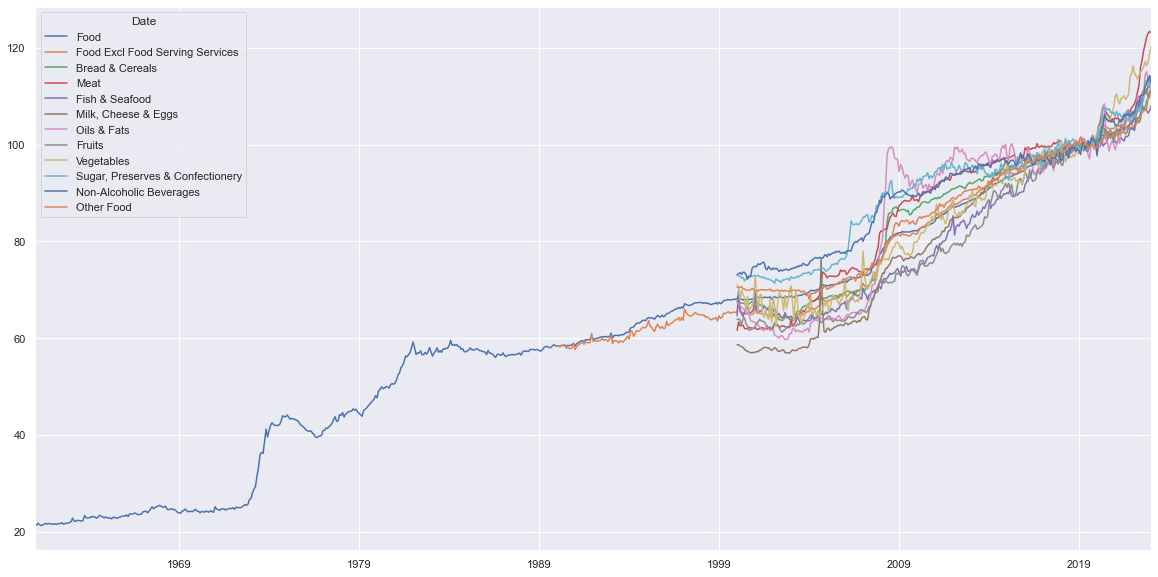

In [63]:
grocery = cpi[['Food','Food Excl Food Serving Services','Bread & Cereals','Meat','Fish & Seafood','Milk, Cheese & Eggs','Oils & Fats','Fruits','Vegetables','Sugar, Preserves & Confectionery','Non-Alcoholic Beverages','Other Food']].replace('na', np.nan)
grocery = grocery.apply(pd.to_numeric)
grocery.plot(figsize=(20, 10))
grocery.head()

<AxesSubplot:>

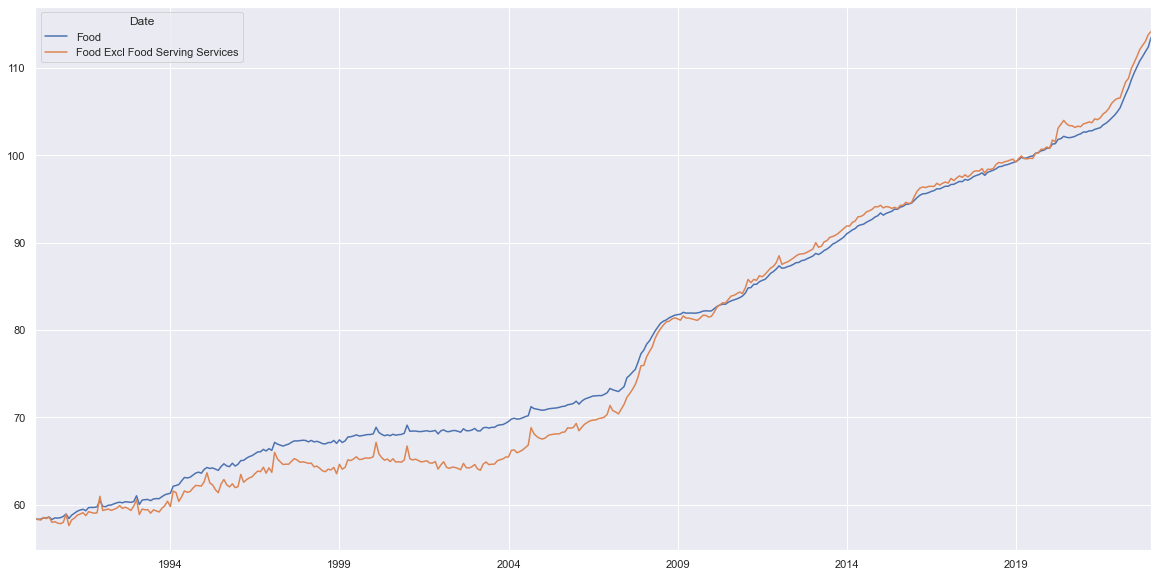

In [64]:
grocery = grocery.iloc[:,0:2]
grocery = grocery.dropna()
grocery.tail()
grocery.plot(figsize=(20, 10))

<AxesSubplot:>

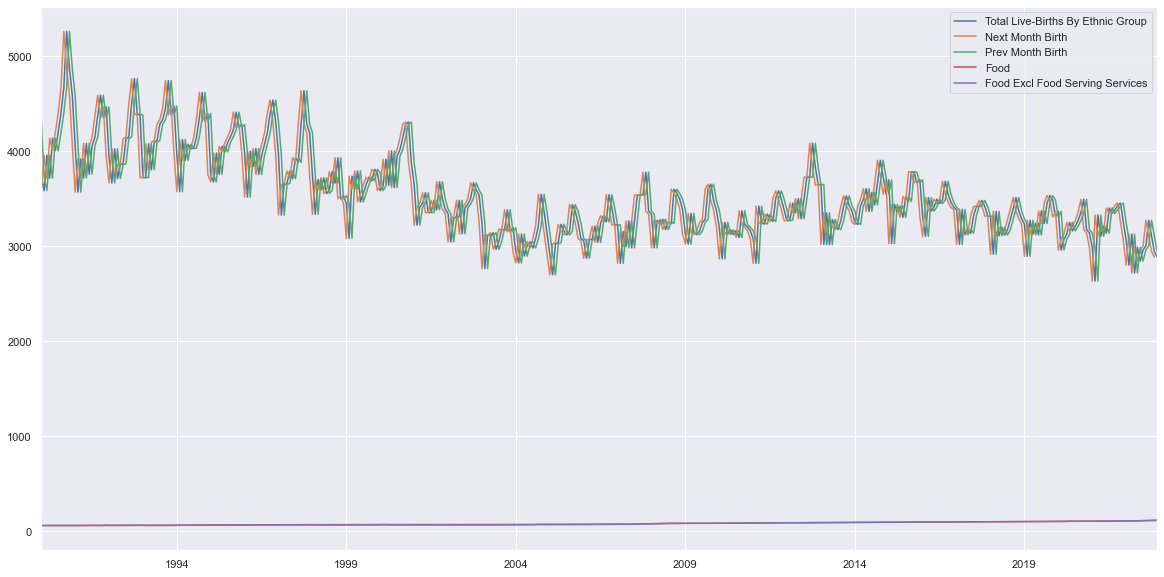

In [66]:
grocerybirths = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
grocerybirths['Next Month Birth'] = grocerybirths['Total Live-Births By Ethnic Group'].shift(-1)
grocerybirths['Prev Month Birth'] = grocerybirths['Total Live-Births By Ethnic Group'].shift(1)

groceryTotal = grocerybirths.join(grocery['Food'], how='inner')
foodexcl = grocerybirths.join(grocery['Food Excl Food Serving Services'], how='inner')

groceryMerge = pd.concat([groceryTotal, foodexcl], axis=1, join='inner')
groceryMerge = groceryMerge.loc[:,~groceryMerge.columns.duplicated(keep='first')]

groceryMerge.plot(figsize=(20, 10))

## 3. Model Training (Classification - Random Forest)
- Predictors:
    - Total Live-Births by Ethnic Group
    - Prev Month Birth
    - Food
    - Food Excl Food Serving Services
- Response: Rise-Fall

In [67]:
# Step 1: Create binary target variable
groceryMerge['Rise-Fall'] = (groceryMerge['Total Live-Births By Ethnic Group'] > groceryMerge['Next Month Birth']).astype(int)

In [76]:
results = []

for seed in seeds:
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = groceryMerge[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Food',
                      'Food Excl Food Serving Services']]

    # Step 2.2: Response
    y = groceryMerge['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [77]:
for res in results:
    print('----------------------------------------------')
    print(f"Random state {res[0]}:")
    print(f'Accuracy  = {res[1]:.4f}')
    print(f'Precision = {res[2]:.4f}')
    print(f'Recall    = {res[3]:.4f}')
    print(f'F1 score  = {res[4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 60903:
Accuracy  = 0.7125
Precision = 0.7143
Recall    = 0.6579
F1 score  = 0.6849
----------------------------------------------
Random state 82516:
Accuracy  = 0.6625
Precision = 0.6222
Recall    = 0.7368
F1 score  = 0.6747
----------------------------------------------
Random state 13453:
Accuracy  = 0.7000
Precision = 0.5833
Recall    = 0.7000
F1 score  = 0.6364
----------------------------------------------
Random state 66193:
Accuracy  = 0.6250
Precision = 0.5455
Recall    = 0.7059
F1 score  = 0.6154
----------------------------------------------
Random state 53391:
Accuracy  = 0.6375
Precision = 0.6389
Recall    = 0.5897
F1 score  = 0.6133
----------------------------------------------


In [78]:
groceryMod = results[0][-1]

# Models Integration (Chee Han)

In [79]:
# Seed to be used for splitting data
seed = random.randint(0, 100000)

# Forming final dataset
finalDataSet = pd.concat([housingMerge, marriageSplit, eduUpdate, 
                          foodMerge, ageMerge, incomeMerge, groceryMerge], axis=1, join='inner').sort_index()
finalDataSet = finalDataSet.loc[:,~finalDataSet.columns.duplicated(keep='first')]

In [80]:
len(finalDataSet)

192

In [81]:
y = finalDataSet['Rise-Fall']
X = finalDataSet.drop(columns=['Rise-Fall', 'Next Month Birth'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [83]:
vc = VotingClassifier(estimators=[('Housing', houseMod), ('Marriage', marriageMod), ('Education Cost', eduCostMod),
                                 ('Food Cost', fooCostMod), ('Marriage Age', marAgeMod), ('Income', incomeMod), 
                                 ('Grocery', groceryMod)], voting='hard')
vc = vc.fit(X_train, y_train)

vcPred = vc.predict(X_test)
print(f'Accuracy: {accuracy_score(vcPred, y_test)}')
print(f'Precision: {precision_score(vcPred, y_test)}')
print(f'Recall: {recall_score(vcPred, y_test)}')
print(f'F1 Score: {f1_score(vcPred, y_test)}')

Accuracy: 0.7435897435897436
Precision: 0.7727272727272727
Recall: 0.7727272727272727
F1 Score: 0.7727272727272727
